In [20]:
import pandas as pd , numpy as np, seaborn as sb, seaborn as sns,warnings, os, matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, StratifiedKFold, RandomizedSearchCV, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score
from scipy.stats import uniform as uni
from sklearn.feature_selection import SelectKBest, chi2,f_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV





warnings.filterwarnings('ignore')
plt.style.use('classic')




# Cargue de los datos y objetivo

El objetivo es realizar un modelo predictivo para predecir la probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9 atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con el valor binario 0 para no fallar y 1 para fallar.

In [2]:
# Cargar base de datos
df = pd.read_csv("full_devices.csv")

## 1. Análisis exploratorio

In [3]:
# Cantidad de registros
print('Cantidad de registros: ',df.shape[0])
print('---'*50)
print('Cantidad de columnas:',df.shape[1])
print('---'*50)
print('Cantidad de Atributos numéricos:', df.select_dtypes(['int']).shape[1])
print('---'*50)
print('Cantidad de Atributos categóricos:', df.select_dtypes(['object']).shape[1])
print('---'*50)
df.head(3)

Cantidad de registros:  124494
------------------------------------------------------------------------------------------------------------------------------------------------------
Cantidad de columnas: 12
------------------------------------------------------------------------------------------------------------------------------------------------------
Cantidad de Atributos numéricos: 0
------------------------------------------------------------------------------------------------------------------------------------------------------
Cantidad de Atributos categóricos: 2
------------------------------------------------------------------------------------------------------------------------------------------------------


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0


Se observa que el data set contiene 12 variables y 124494 registros.Se crea un nuevo dataframe 'df_2' para realizar el análisis descriptivo de los datos. Esto con el fin de no tocar el dataframe original 'df' ya que éste no debe ser tocado.

In [4]:
## Se crea un nuevo dataframe para realizar el análisis exploratorio 
df_2 = df.copy()

Valores faltantes por variable numérica: 

failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------


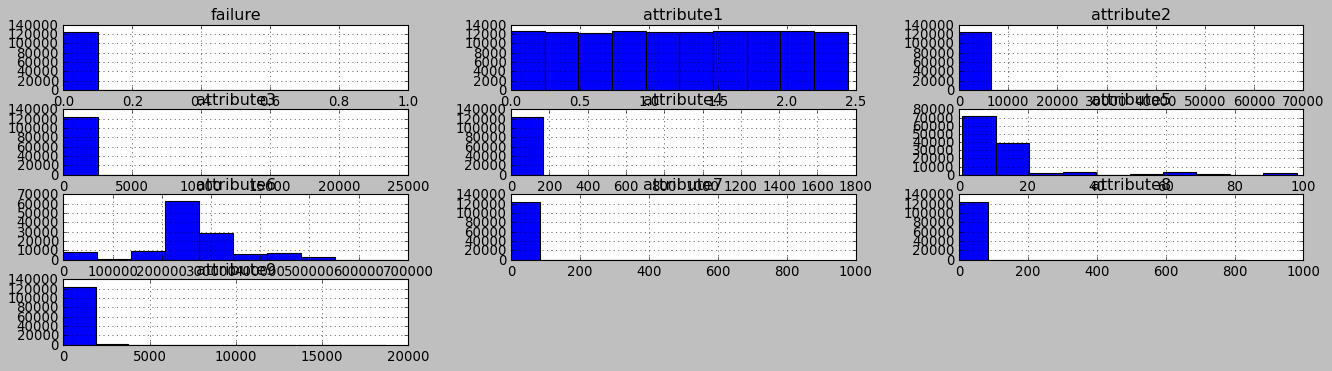

In [5]:

# se seleccionan las columnas de las variables numéricas
var_num =np.array(df_2.select_dtypes(['int64', 'float']).columns)

var_num = list(var_num)
var_num = [i for i in var_num]
print('Valores faltantes por variable numérica:', '\n')
print(df[var_num].isna().sum())
print('---'*50)
df_2[var_num].hist(ec='black', figsize=(20,5));

Se observa que ninguna de las variables numéricas presenta valores faltantes. Por otro lado, algunas de ellas presentan un gran sesgo en su distribución, esto puede significar que los valores en estas variables tienden a concentrarse en un rango puntual, lo cual no genera una buena variación entre los datos y consecuentemente, no pueden ser buenos predictores.

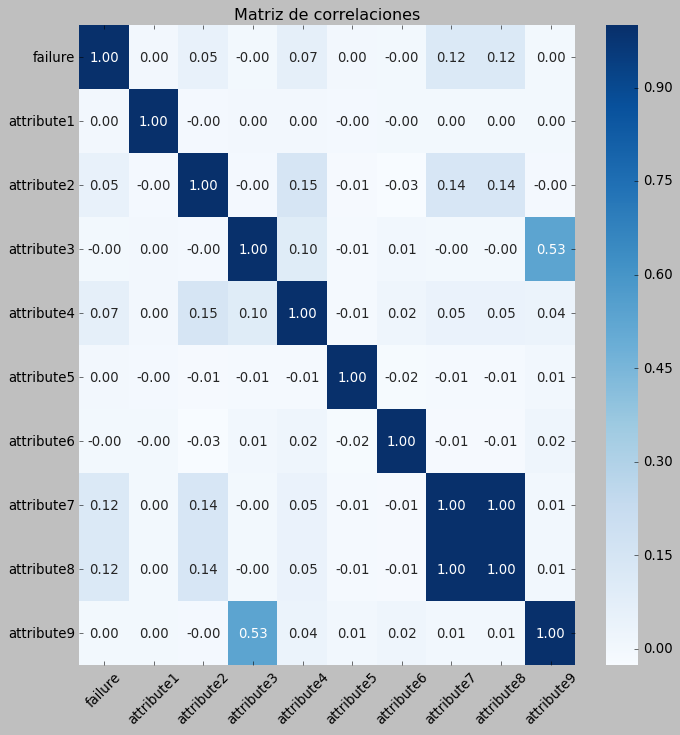

In [6]:
corr = df_2.corr()

fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.Blues

ax = sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f')

ax.set_xticklabels(corr.index, rotation=45)
ax.set_yticklabels(corr.index)

ax.set_title('Matriz de correlaciones')

plt.show()


Se observa que las variables 'attribute7' y 'attribute8' estan perfectamente corelacionadas por lo que una de estas no sera tenida en cuenta al momento de realizar el modelo.

### 1.1. Variable de respuesta 'failure'

In [7]:
table = df_2['failure'].value_counts().to_frame()
table.rename(columns={'failure': 'Frecuencia'}, inplace=True)

# Mostrar la tabla
print(table)

   Frecuencia
0      124388
1         106


   Frecuencia
0      124388
1         106


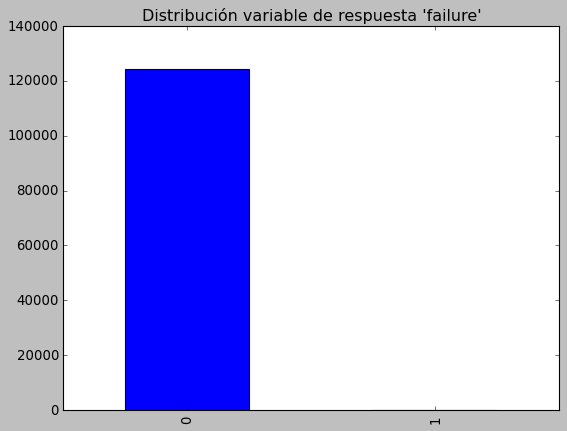

In [8]:
df_2['failure'].value_counts().plot(kind='bar')
plt.title("Distribución variable de respuesta 'failure'")

table = df_2['failure'].value_counts().to_frame()
table.rename(columns={'failure': 'Frecuencia'}, inplace=True)
print(table)

plt.show()

## 2. PARTICIÓN ENTRENAMIENTO - TEST & MODELAMIENTO

Aspectos a tener en cuenta:

1. Al tratarse de un problema de clasificación, se usarán como 'base' los modelos de Regresión logística, Random Forest y Decision Tree así como un modelo de votación como VoteClassifier. 
2. Los modelos base NO INCLUIRAN las variables 'attribute8', 'date' y 'device' .
3. Se realizará una calibración de hiperparámetros para estos modelos con el fin de comparar sus resultados contra los modelos 'base'.
6. El modelamiento se hará sobre el dataframe original 'df'.
7. Se hará uso de PipeLines para facilitar los pasos de preprocesamiento y modelamiento.

In [9]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [40]:
# Eliminar variables
eliminar = ['attribute8', 'date', 'device','failure' ]

X = df.drop(eliminar, axis=1)
y = df['failure']

# Partición Train - Test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

"""  DEFINICIÓN DEL PIPELINE PARA EVALUAR LOS MODELOS """ 

# Preprocesamiento de variables numéricas
num_trans = Pipeline(steps=[('scalar', StandardScaler())])
prepro = ColumnTransformer(transformers=[("num", num_trans, list(X.select_dtypes('number').columns))])

""" OVERSAMPLING """
strategy = {0: 124388, 1: 106}
oversample = SMOTE(sampling_strategy=strategy)


""" Se generan ahora los pipelines para los modelos a evaluar """
mod_log_reg = Pipeline(steps=[('num_trans', num_trans),('over_sam', oversample),('reg_log', LogisticRegression(solver='sag', C=1e5))])

mod_grad = Pipeline(steps=[('num_trans', num_trans),('over_sam', oversample),('grad_b', GradientBoostingClassifier())])

mod_randfor = Pipeline(steps=[('num_trans', num_trans),('over_sam', oversample),('random_for', RandomForestClassifier(criterion='entropy', class_weight='balanced'))])

mod_voter = Pipeline(steps=[('preproce',prepro),('random_for',VotingClassifier(estimators=[('log_r', LogisticRegression()),
                                                                     ('ran_f', RandomForestClassifier() ),
                                                                     ('dec_t', GradientBoostingClassifier())], voting='soft'))])

## Modelo One vs Rest Random Forest

mod_onevsr_randfor = Pipeline(steps=[('preproce',prepro),
                          ('random_for', OneVsRestClassifier(RandomForestClassifier()))])


## Particion de folds y validación cruzada de los modelos
k_f = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)






In [41]:
# Define la métrica de evaluación (AUC-ROC ponderado)
metric = 'roc_auc_ovr_weighted'

# Define el error de puntuación para evitar errores
error_score = 'raise'

# Define el pipeline para el Random Forest
mod_randfor = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('random_for', RandomForestClassifier(criterion='entropy', class_weight='balanced'))
])

# Define el pipeline para el Gradient Boosting
mod_grad = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('grad_b', GradientBoostingClassifier())
])

# Realiza la validación cruzada para el Random Forest
val_cros_rf = cross_val_score(mod_randfor, X_train, y_train, cv=k_f, scoring=metric, error_score=error_score)

# Realiza la validación cruzada para el Gradient Boosting
val_cros_grad = cross_val_score(mod_grad, X_train, y_train, cv=k_f, scoring=metric, error_score=error_score)

# Imprime los resultados de la validación cruzada
print(f"AUC-ROC ponderado del Random Forest: {np.mean(val_cros_rf):.4f} (+/- {np.std(val_cros_rf):.4f})")
print(f"AUC-ROC ponderado del Gradient Boosting: {np.mean(val_cros_grad):.4f} (+/- {np.std(val_cros_grad):.4f})")


AUC-ROC ponderado del Random Forest: 0.7604 (+/- 0.0479)
AUC-ROC ponderado del Gradient Boosting: 0.8337 (+/- 0.0176)


No handles with labels found to put in legend.


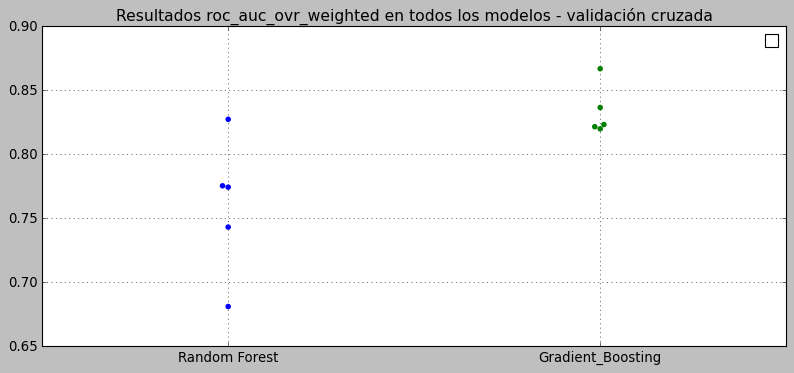

In [42]:
df_res_cro_val = pd.DataFrame({'Random Forest':val_cros_rf, 'Gradient_Boosting':val_cros_grad})
                                

#Gráfico con resultados de validación cruzada
plt.figure(figsize=(12,5))
sb.swarmplot(data=df_res_cro_val)
plt.title('Resultados roc_auc_ovr_weighted en todos los modelos - validación cruzada',fontsize=14)
plt.grid(True)
plt.legend();

Se observa como el modelo de Gradient Boosting presenta un mejor comportamiento a nivel de validación que el modelo de Random Forest.